# Overview

This colab demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image. Expected outputs are semantic labels overlayed on the sample image.

### About DeepLab
The models used in this colab perform semantic segmentation. Semantic segmentation models focus on assigning semantic labels, such as sky, person, or car, to multiple objects and stuff in a single image.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [2]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

Download completed! Extracting model...
Extracted: ['deeplabv3_mnv2_pascal_train_aug', 'deeplabv3_mnv2_pascal_train_aug/model.ckpt-30000.index', 'deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb', 'deeplabv3_mnv2_pascal_train_aug/model.ckpt-30000.data-00000-of-00001']
Frozen model path: /tmp/tmprbckj1h4/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
Converting frozen graph to SavedModel format...
SavedModel successfully created at /tmp/tmprbckj1h4/saved_model
Loading DeepLab model...
Model loaded successfully!


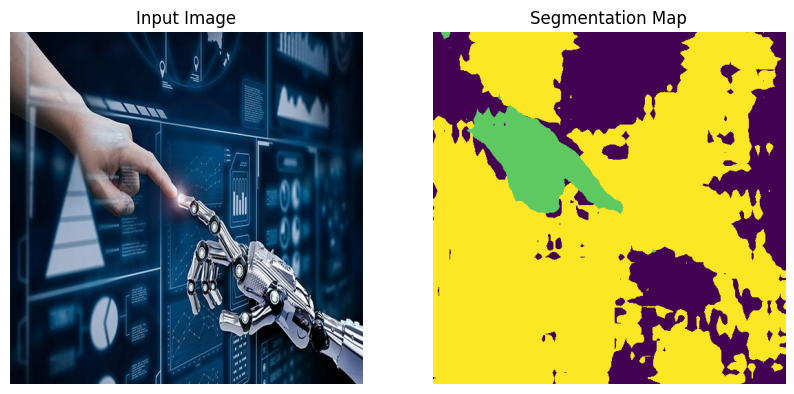

In [15]:
import os
import tarfile
import tempfile
import urllib.request
import tensorflow as tf
import numpy as np
import shutil
from PIL import Image
import matplotlib.pyplot as plt

# Define model selection
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # Choose from available models

# Model download URLs
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug': 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval': 'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug': 'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval': 'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

# Set up directories
_TARBALL_NAME = 'deeplab_model.tar.gz'
model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

# Download model
download_path = os.path.join(model_dir, _TARBALL_NAME)
print('Downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('Download completed! Extracting model...')

# Extract model
with tarfile.open(download_path, 'r:gz') as tar:
    tar.extractall(model_dir)
    extracted_files = tar.getnames()
    print("Extracted:", extracted_files)

# Find frozen inference graph
frozen_graph_path = None
for root, _, files in os.walk(model_dir):
    for file in files:
        if file == "frozen_inference_graph.pb":
            frozen_graph_path = os.path.join(root, file)
            break
if not frozen_graph_path:
    raise RuntimeError("Frozen inference graph not found!")

print(f"Frozen model path: {frozen_graph_path}")

# Convert frozen graph to SavedModel
saved_model_dir = os.path.join(model_dir, "saved_model")
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)  # Remove if already exists
os.makedirs(saved_model_dir)

# Load frozen graph
def load_frozen_graph(frozen_graph_path):
    """Loads a frozen inference graph from file."""
    with tf.io.gfile.GFile(frozen_graph_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

# Convert frozen graph to SavedModel
print("Converting frozen graph to SavedModel format...")
graph_def = load_frozen_graph(frozen_graph_path)

# Import the frozen graph into a new TF2 function
class DeepLabModel(tf.Module):
    def __init__(self, graph_def):
        super().__init__()
        self.graph_def = graph_def

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.uint8)])
    def infer(self, image):
        """Runs inference using the DeepLab model."""
        outputs = tf.compat.v1.wrap_function(
            lambda: tf.import_graph_def(self.graph_def, name=""),
            []
        )
        output_tensor = outputs.graph.get_tensor_by_name("SemanticPredictions:0")
        input_tensor = outputs.graph.get_tensor_by_name("ImageTensor:0")
        return outputs.prune(input_tensor, output_tensor)(image)

# Save the model in TF2 format
model = DeepLabModel(graph_def)
tf.saved_model.save(model, saved_model_dir)
print(f"SavedModel successfully created at {saved_model_dir}")

# Load the model for inference
print("Loading DeepLab model...")
MODEL = tf.saved_model.load(saved_model_dir)
print("Model loaded successfully!")

# Function to run inference
def run_inference(image_path):
    """Runs DeepLab model inference on an image."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = Image.open(image_path).convert("RGB")
    image_resized = image.resize((513, 513), Image.LANCZOS)
    image_np = np.array(image_resized, dtype=np.uint8)  # Ensure uint8 type

    # Run inference
    image_tensor = tf.convert_to_tensor([image_np], dtype=tf.uint8)
    seg_map = MODEL.infer(image_tensor)[0].numpy()

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized)
    plt.axis("off")
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(seg_map, cmap="viridis")
    plt.axis("off")
    plt.title("Segmentation Map")

    plt.show()

# Example usage:
image_path = "/content/bg.jpg"  # Make sure the image exists
run_inference(image_path)
